In [1]:
"""
This notebook attemps to predict the future sales data
"""

'\nThis notebook attemps to predict the future sales data\n'

In [2]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load data

In [13]:
_data_dir = 'all//'

### Train set

In [14]:
train = pd.read_csv(_data_dir + 'sales_train_v2.csv')
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train.set_index(pd.DatetimeIndex(train['date']), inplace=True)
del train['date']
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-02,0,59,22154,999.00,1.0
2013-01-03,0,25,2552,899.00,1.0
2013-01-05,0,25,2552,899.00,-1.0
2013-01-06,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


### Test set

In [15]:
test = pd.read_csv(_data_dir + 'test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### Meta data

In [16]:
items = pd.read_csv(_data_dir + 'items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [17]:
categories = pd.read_csv(_data_dir + 'item_categories.csv')
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [18]:
shops = pd.read_csv(_data_dir + 'shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [19]:
items.shape, categories.shape, shops.shape

((22170, 3), (84, 2), (60, 2))

#### Sanity - Distribution of daily sales prices and counts

count    21807.000000
mean       134.628743
std        406.938186
min          1.000000
25%          6.000000
50%         32.000000
75%        119.000000
max      31340.000000
dtype: float64

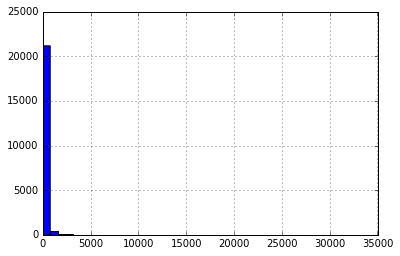

In [20]:
#counts per item - most items have very few counts, as expected
counts_per_item = train.groupby('item_id').apply(len)
counts_per_item.hist(bins=40)
counts_per_item.describe()

In [21]:
print(train[train.item_cnt_day < 0].shape)

(7356, 5)


In [22]:
train.item_cnt_day.quantile(0.99)

5.0

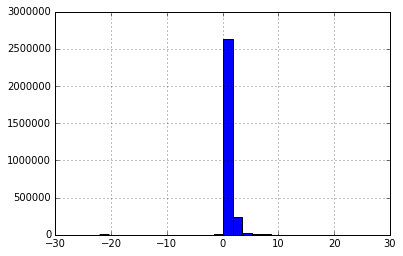

In [23]:
train[train.item_cnt_day < 30].item_cnt_day.hist(bins=30)

In [24]:
train.item_cnt_day.min()

-22.0

In [25]:
train[train.item_cnt_day < 0].date_block_num.unique().shape # not specific to a certain month

(34,)

In [26]:
def count_pct_neg(g):
    return pd.Series(
        {'pct': len(g[g.item_cnt_day < 0]) / float(len(g)),
         'neg_count': len(g[g.item_cnt_day < 0])})

pct_neg_counts = train.groupby('item_id').apply(count_pct_neg)
pct_neg_counts.sort_values(by='neg_count').tail(10) #basically looks like bad data

,neg_count,pct
item_id,,
5613,24.0,0.040678
4249,24.0,0.007595
4244,24.0,0.006494
6675,24.0,0.004686
16787,27.0,0.005111
4332,27.0,0.020331
5672,31.0,0.007864
1915,32.0,0.014286
3734,41.0,0.007063


In [27]:
pct_shop_neg_counts = train.groupby('shop_id').apply(count_pct_neg)
pct_shop_neg_counts.sort_values(by='pct').tail(10) #basically looks like bad data

,neg_count,pct
shop_id,,
37,154.0,0.003885
48,89.0,0.004118
44,165.0,0.004174
32,34.0,0.004278
34,25.0,0.004346
33,22.0,0.004376
3,119.0,0.004661
43,211.0,0.005371
36,3.0,0.009804


In [28]:
train.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [29]:
train[train.item_price < 1].item_id.unique().shape

(67,)

### Set negative values to NaN

In [30]:
train.loc[train.item_price < 0, 'item_price'] = np.nan
train.loc[train.item_cnt_day < 0, 'item_cnt_day'] = np.nan

In [31]:
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-02,0,59,22154,999.00,1.0
2013-01-03,0,25,2552,899.00,1.0
2013-01-05,0,25,2552,899.00,NaN
2013-01-06,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


## Exploratory data analysis

### --> simplifiying - turn data into monthly sales

In [78]:
func = {'date_block_num':['mean'], 'item_price':['mean'], 'item_cnt_day':['sum']}

In [79]:
train_monthly = train.groupby([(train.index.year),(train.index.month), 'shop_id', 'item_id']).agg(func)
train_monthly.index.names = ['year', 'month', 'shop_id', 'item_id']
train_monthly.columns = [u'date_block_num', u'item_price', u'item_cnt_day']   # remove column lables (from the aggregation)
train_monthly.head()

date_block_num  item_price  item_cnt_day
year month shop_id item_id                                          
2013 1     0       32                    0         6.0         221.0
                   33                    0         3.0         347.0
                   35                    0         1.0         247.0
                   43                    0         1.0         221.0
                   51                    0         2.0         128.5

## --> sales by time of year

In [80]:
res = train_monthly.groupby(level=['year','month'])[['item_cnt_day']].sum()
res.head()

item_cnt_day
year month              
2013 1      4.120841e+07
     2      3.815273e+07
     3      4.120814e+07
     4      3.458265e+07
     5      3.278247e+07

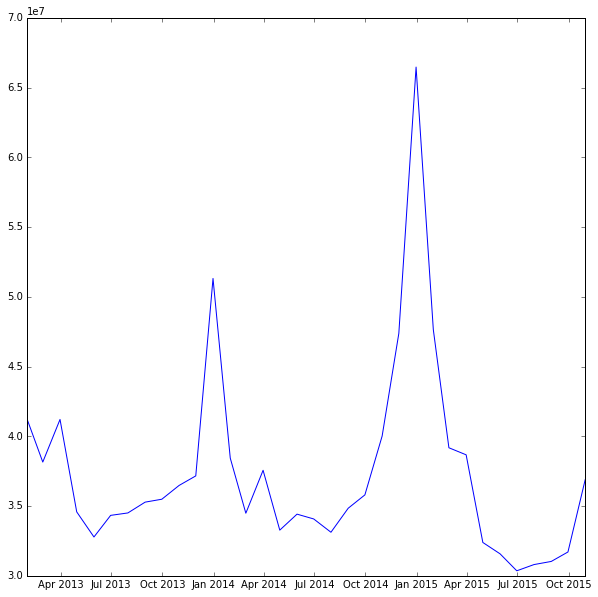

In [35]:
plot(pd.date_range(start='2013-01', end='2015-11', freq='M'), res.item_cnt_day.values);
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

In [36]:
res_by_shop = train_monthly.groupby(level=['year','month', 'shop_id'])[['item_cnt_day']].sum()
res_by_shop.head()

item_cnt_day
year month shop_id              
2013 1     0        1.054189e+06
           1        7.060488e+05
           2        6.504452e+05
           3        4.045965e+05
           4        7.286346e+05

In [37]:
res_by_shop.xs(0, level='shop_id').head()

item_cnt_day
year month              
2013 1      1.054189e+06
     2      1.171276e+06

In [75]:
def _convert_back_to_date_time(g):
    return datetime.datetime(int(g['year']), int(g['month']), 1)

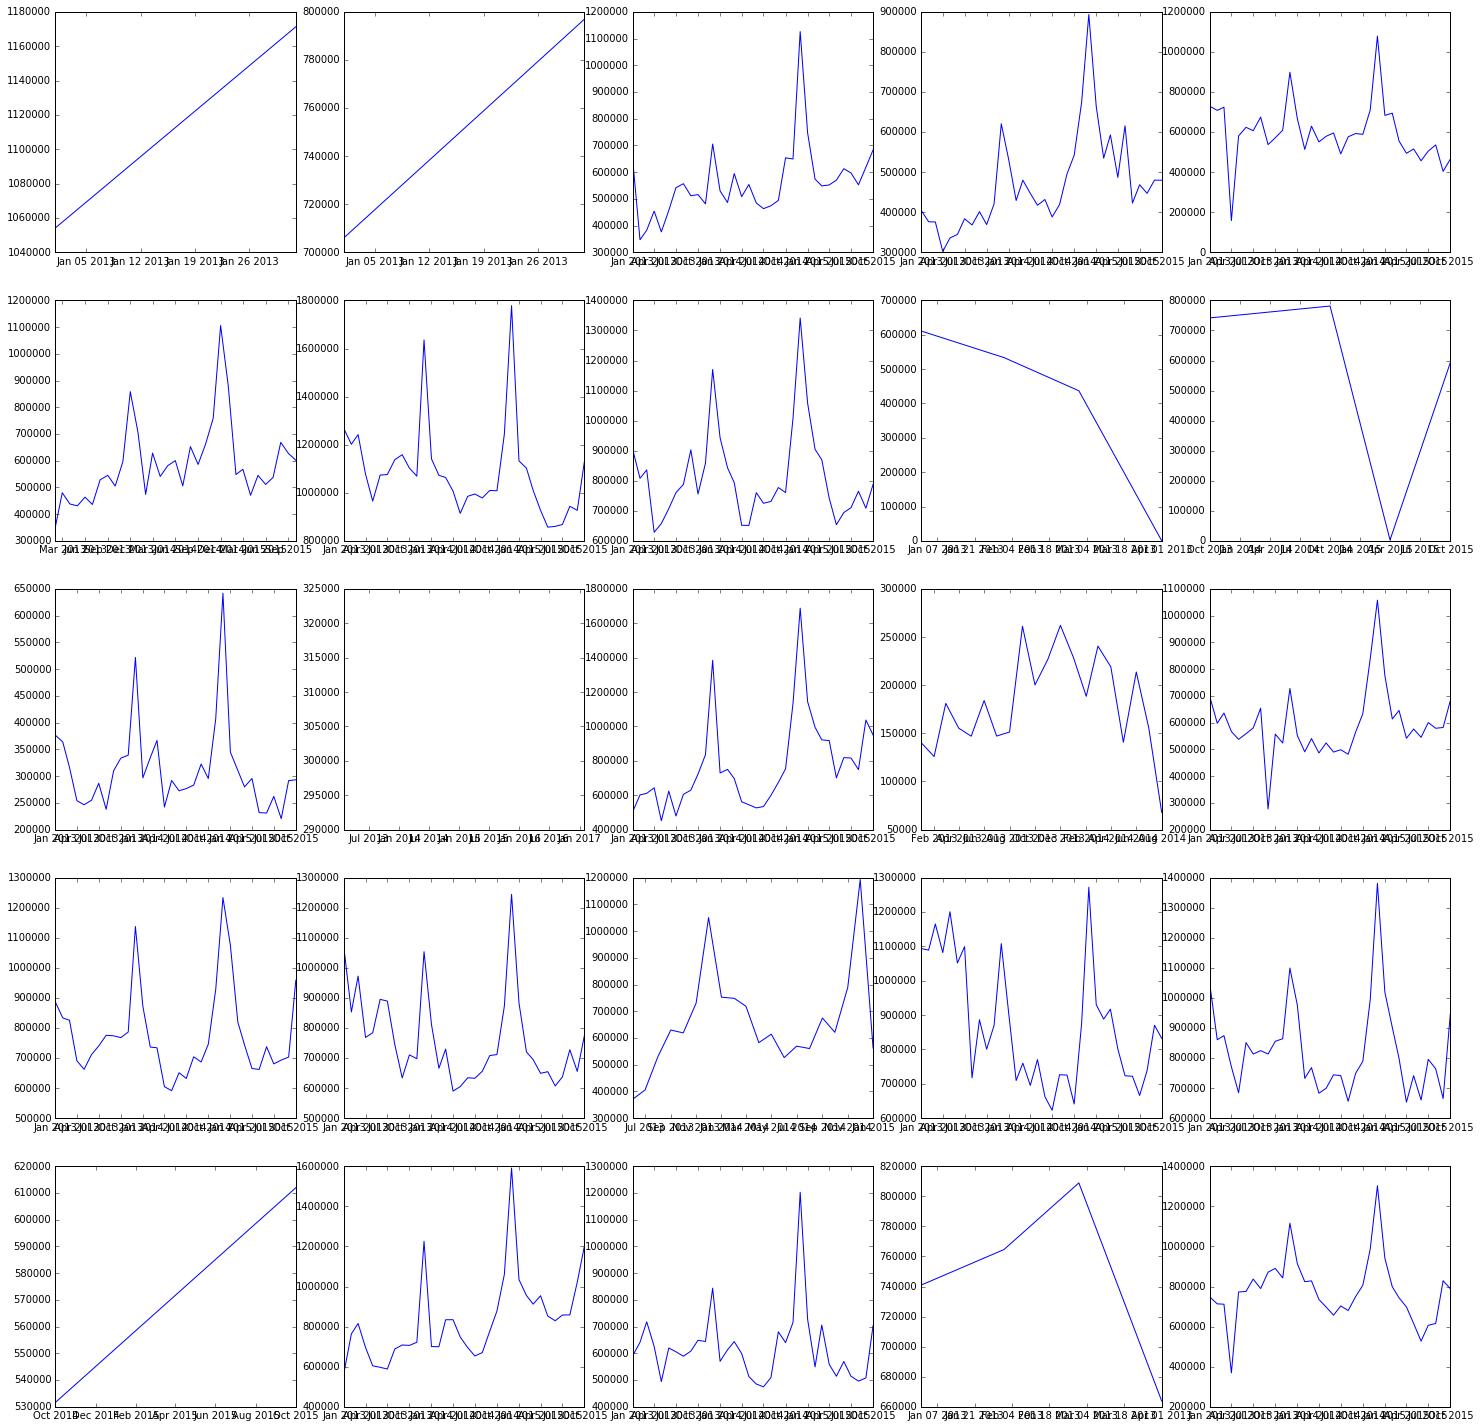

In [77]:
figure(figsize=(25,25))
for i in range(25):
    data = res_by_shop.xs(i, level='shop_id').reset_index()
    data['month_year'] = data.apply(_convert_back_to_date_time, 1)
    subplot(5,5,i+1)
    plot(data.month_year.values, data.item_cnt_day.values);

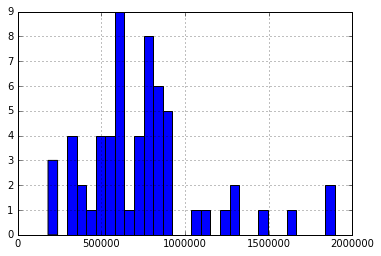

In [83]:
#mean per shop
res_by_shop.groupby(level='shop_id').item_cnt_day.mean().hist(bins=30)

In [84]:
train_monthly_w_categories = train_monthly.reset_index().merge(items, on='item_id', how='left')
res_by_category = train_monthly_w_categories.groupby(
    ['year','month', 'item_category_id'])[['item_cnt_day']].sum()


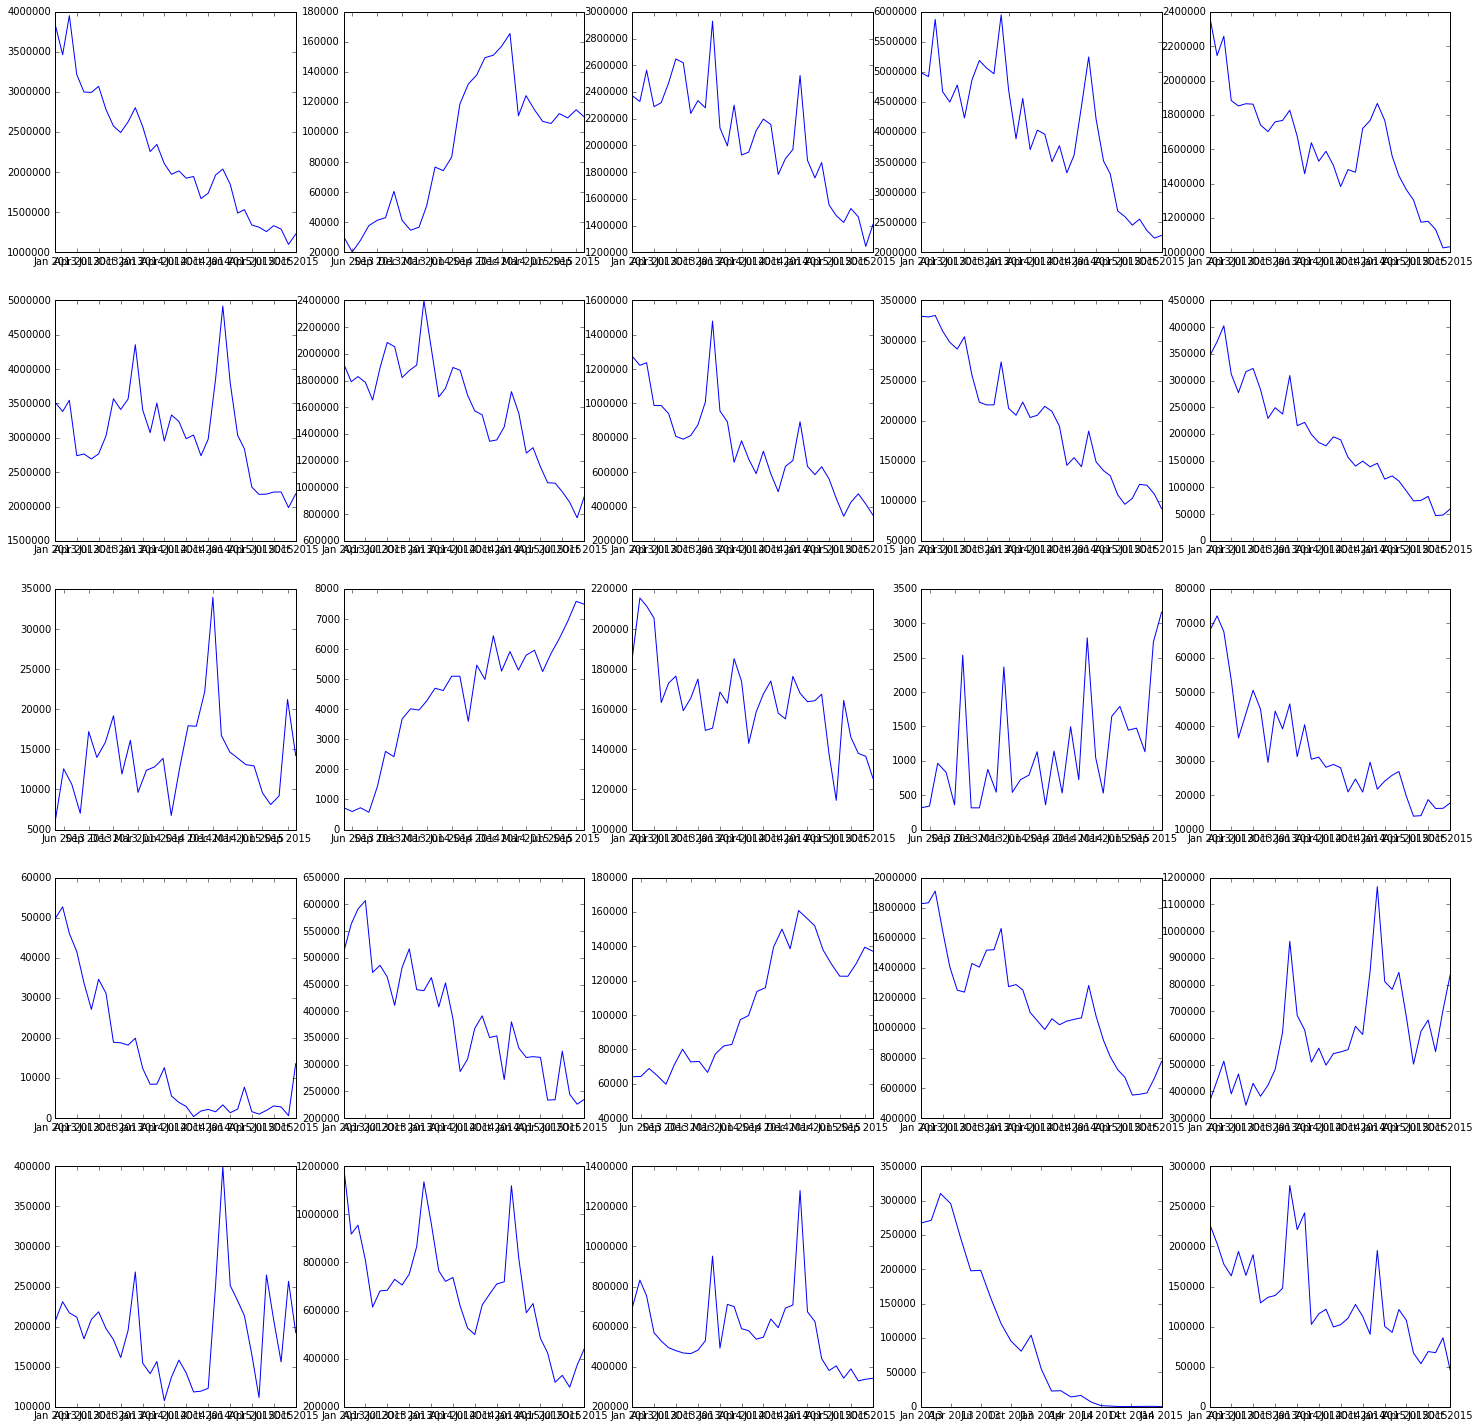

In [85]:
all_categories = items.item_category_id.unique().tolist()
figure(figsize=(25,25))
for i in range(25):
    data = res_by_category.xs(all_categories[i], level='item_category_id').reset_index()
    data['month_year'] = data.apply(_convert_back_to_date_time, 1)
    subplot(5,5,i+1)
    plot(data.month_year.values, data.item_cnt_day.values);

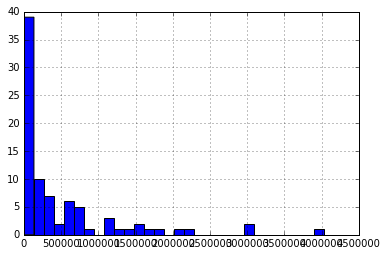

In [86]:
#mean per category
res_by_category.groupby(level='item_category_id').item_cnt_day.mean().hist(bins=30)

In [87]:
# Thoughts

# Features: 
# item_id, shop_id, 
# price last month, 
# avg price last moth across shops,
# avg across years of item sales per month in all stores, 
# category avg sales in shop, 
# shop avg sales per month across years, last month sales, 
# last year same months sales per item and shop
# ??

# should we use something like this - https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

# should we smooth out train data? should we impute based on other items in category?